<a href="https://colab.research.google.com/github/IshaanKetchup/OCR/blob/main/Model%20Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Setup and Load Data

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt

# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load EMNIST ByClass dataset (contains A-Z, a-z, 0-9, etc.)
train_dataset = torchvision.datasets.EMNIST(
    root='./data',
    split='byclass',
    train=True,
    download=True,
    transform=transform
)

test_dataset = torchvision.datasets.EMNIST(
    root='./data',
    split='byclass',
    train=False,
    download=True,
    transform=transform
)

# EMNIST ByClass has 62 classes (0-9, A-Z, a-z)
# We need to filter only A-Z (10-35) and a-z (36-61)
def filter_alphabets(dataset):
    # Get the labels
    labels = np.array(dataset.targets)

    # Filter indices for A-Z and a-z
    mask = ((labels >= 10) & (labels <= 35)) | ((labels >= 36) & (labels <= 61))
    indices = np.where(mask)[0]

    # Create subset
    return Subset(dataset, indices)

# Apply filter
train_dataset = filter_alphabets(train_dataset)
test_dataset = filter_alphabets(test_dataset)

# Create data loaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Print dataset information
print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Using device: cuda:0


100%|██████████| 562M/562M [00:12<00:00, 45.0MB/s]


Train dataset size: 352897
Test dataset size: 58405


##Visualizing the data

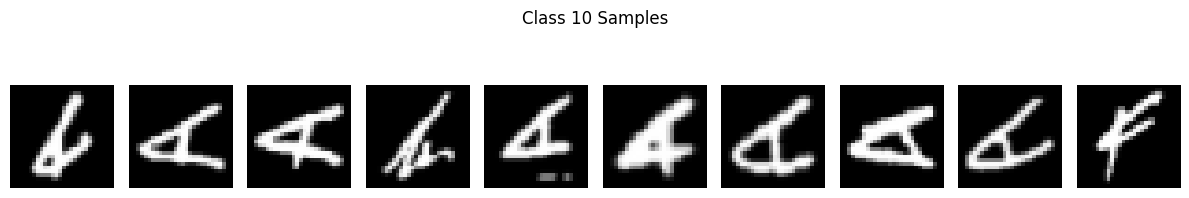

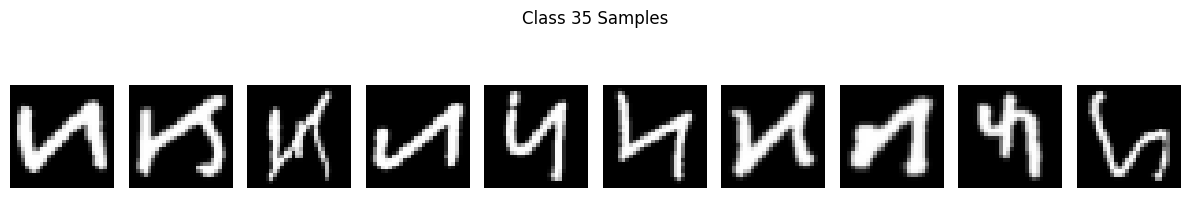

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def show_class_samples(dataset, class_id, num_samples=10):
    """
    Display sample images from a specific class in the EMNIST dataset.

    Args:
        dataset: EMNIST dataset (train or test)
        class_id: The class to display (0-61 in original EMNIST ByClass)
                 10-35: A-Z
                 36-61: a-z
        num_samples: Number of samples to display
    """
    # Get the indices of samples from the specified class
    if isinstance(dataset, torch.utils.data.Subset):
        # Handle filtered dataset
        all_labels = np.array(dataset.dataset.targets)[dataset.indices]
    else:
        # Handle full dataset
        all_labels = np.array(dataset.targets)

    class_indices = np.where(all_labels == class_id)[0]

    # Limit to the available samples
    num_samples = min(num_samples, len(class_indices))

    # Create figure
    plt.figure(figsize=(12, 2))
    plt.suptitle(f"Class {class_id} Samples", y=1.05)

    # Display samples
    for i, idx in enumerate(class_indices[:num_samples]):
        # For Subset, we need to get the original dataset index
        if isinstance(dataset, torch.utils.data.Subset):
            original_idx = dataset.indices[idx]
            image, _ = dataset.dataset[original_idx]
        else:
            image, _ = dataset[idx]

        plt.subplot(1, num_samples, i+1)
        plt.imshow(image.squeeze().numpy(), cmap='gray')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Mapping from letters to class IDs
def get_class_id(letter):
    """
    Get the EMNIST ByClass class ID for a given letter.
    Args:
        letter: A single character (A-Z or a-z)
    Returns:
        The corresponding class ID in EMNIST ByClass
    """
    if len(letter) != 1:
        raise ValueError("Input must be a single character")

    if letter.isupper():
        return 10 + ord(letter) - ord('A')
    elif letter.islower():
        return 36 + ord(letter) - ord('a')
    else:
        raise ValueError("Character must be A-Z or a-z")

# Example usage:
# Show samples for letter 'A' (class 10 in EMNIST ByClass)
show_class_samples(train_dataset, get_class_id('A'))

# Show samples for letter 'z' (class 61 in EMNIST ByClass)
show_class_samples(train_dataset, get_class_id('Z'))

In [ ]:
# Print the class ID mapping for all letters
print("Uppercase letters:")
for letter in 'ABCDEFGHIJKLMNOPQRSTUVWXYZ':
    print(f"{letter}: {get_class_id(letter)}")

print("\nLowercase letters:")
for letter in 'abcdefghijklmnopqrstuvwxyz':
    print(f"{letter}: {get_class_id(letter)}")

Uppercase letters:
A: 10
B: 11
C: 12
D: 13
E: 14
F: 15
G: 16
H: 17
I: 18
J: 19
K: 20
L: 21
M: 22
N: 23
O: 24
P: 25
Q: 26
R: 27
S: 28
T: 29
U: 30
V: 31
W: 32
X: 33
Y: 34
Z: 35

Lowercase letters:
a: 36
b: 37
c: 38
d: 39
e: 40
f: 41
g: 42
h: 43
i: 44
j: 45
k: 46
l: 47
m: 48
n: 49
o: 50
p: 51
q: 52
r: 53
s: 54
t: 55
u: 56
v: 57
w: 58
x: 59
y: 60
z: 61


##Model Architecture

In [ ]:
class OCRNet(nn.Module):
    def __init__(self, num_classes=52):
        super(OCRNet, self).__init__()
        self.features = nn.Sequential(
            # Input: 1x28x28 (EMNIST images are 28x28)
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(128 * 3 * 3, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.5),

            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.classifier(x)
        return x

# Create model
model = OCRNet(num_classes=52).to(device)
print(model)

OCRNet(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=1152, out_features=256, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=Tr

##Training Setup

In [ ]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Function to calculate accuracy
def calculate_accuracy(outputs, labels):
    _, predicted = torch.max(outputs.data, 1)
    total = labels.size(0)
    correct = (predicted == labels).sum().item()
    return 100 * correct / total

##Training Loop

In [ ]:
num_epochs = 15
train_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_acc = 0.0
    total = 0

    for i, (inputs, labels) in enumerate(train_loader):
        # Skip the last batch if it has only 1 sample
        if inputs.size(0) == 1:
            continue

        # Adjust labels (A-Z:10-35 -> 0-25, a-z:36-61 -> 26-51)
        labels = torch.where(labels <= 35, labels - 10, labels - 36 + 26)

        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item()
        running_acc += calculate_accuracy(outputs, labels)
        total += 1

    # Update learning rate
    scheduler.step()

    # Calculate epoch statistics
    epoch_loss = running_loss / total if total > 0 else 0
    epoch_acc = running_acc / total if total > 0 else 0
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    # Evaluate on test set
    model.eval()
    test_acc = 0.0
    test_total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            # Skip if batch size is 1
            if inputs.size(0) == 1:
                continue

            # Adjust labels as before
            labels = torch.where(labels <= 35, labels - 10, labels - 36 + 26)

            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            test_acc += calculate_accuracy(outputs, labels)
            test_total += 1

    test_acc = test_acc / test_total if test_total > 0 else 0
    test_accuracies.append(test_acc)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}%, Test Acc: {test_acc:.2f}%")

print("Training finished!")

Epoch 1/15, Loss: 0.4205, Train Acc: 84.83%, Test Acc: 85.70%
Epoch 2/15, Loss: 0.3965, Train Acc: 85.45%, Test Acc: 86.38%
Epoch 3/15, Loss: 0.3793, Train Acc: 85.94%, Test Acc: 86.46%
Epoch 4/15, Loss: 0.3663, Train Acc: 86.33%, Test Acc: 86.28%
Epoch 5/15, Loss: 0.3565, Train Acc: 86.68%, Test Acc: 86.70%
Epoch 6/15, Loss: 0.3241, Train Acc: 87.66%, Test Acc: 87.22%
Epoch 7/15, Loss: 0.3146, Train Acc: 88.03%, Test Acc: 87.22%
Epoch 8/15, Loss: 0.3084, Train Acc: 88.16%, Test Acc: 87.28%
Epoch 9/15, Loss: 0.3045, Train Acc: 88.24%, Test Acc: 87.26%
Epoch 10/15, Loss: 0.3011, Train Acc: 88.37%, Test Acc: 87.19%
Epoch 11/15, Loss: 0.2950, Train Acc: 88.59%, Test Acc: 87.26%
Epoch 12/15, Loss: 0.2945, Train Acc: 88.58%, Test Acc: 87.26%
Epoch 13/15, Loss: 0.2937, Train Acc: 88.57%, Test Acc: 87.26%
Epoch 14/15, Loss: 0.2932, Train Acc: 88.63%, Test Acc: 87.21%
Epoch 15/15, Loss: 0.2931, Train Acc: 88.61%, Test Acc: 87.26%
Training finished!


##Visualization and Evaluation

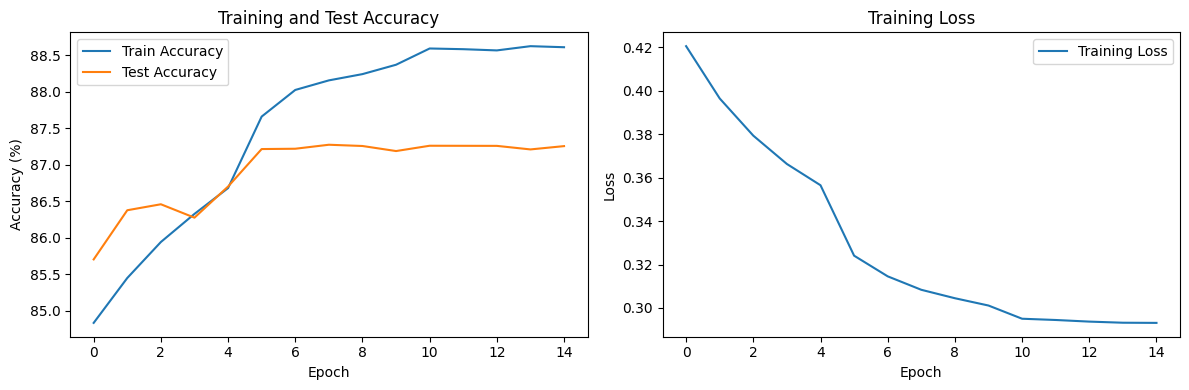

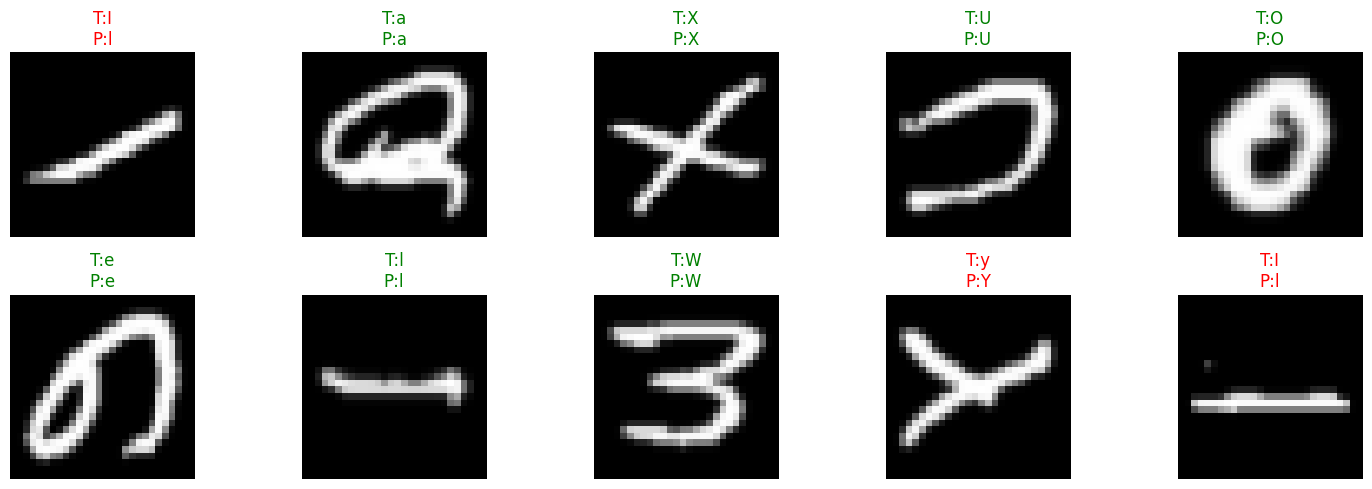

In [ ]:
# Plot training and test accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Training and Test Accuracy')

plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss')

plt.tight_layout()
plt.show()

# Function to visualize predictions
def visualize_predictions(num_images=10):
    model.eval()
    dataiter = iter(test_loader)
    images, labels = next(dataiter)

    # Adjust labels
    orig_labels = labels.clone()
    labels = torch.where(labels <= 35, labels - 10, labels - 36 + 26)

    images, labels = images.to(device), labels.to(device)

    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

    # Create mapping from class index to character
    class_to_char = {}
    for i in range(26):
        class_to_char[i] = chr(ord('A') + i)
    for i in range(26, 52):
        class_to_char[i] = chr(ord('a') + i - 26)

    # Plot images with predictions
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        plt.subplot(2, num_images//2, i+1)
        img = images[i].cpu().squeeze()
        plt.imshow(img, cmap='gray')

        # Get original label (before our adjustment)
        orig_label = orig_labels[i].item()
        if orig_label <= 35:
            true_char = chr(ord('A') + orig_label - 10)
        else:
            true_char = chr(ord('a') + orig_label - 36)

        pred_char = class_to_char[predicted[i].item()]

        title_color = 'green' if true_char == pred_char else 'red'
        plt.title(f"T:{true_char}\nP:{pred_char}", color=title_color)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

visualize_predictions()

In [ ]:
# Save the model
torch.save(model.state_dict(), 'emnist_ocr_model.pth')

# To load the model later:
# model = OCRNet(num_classes=52).to(device)
# model.load_state_dict(torch.load('emnist_ocr_model.pth'))
# model.eval()

#Prediction on Custom Input

##Load the Saved Model

In [ ]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import numpy as np

# Define the model architecture (must match your training architecture)
class OCRNet(nn.Module):
    def __init__(self, num_classes=52):
        super(OCRNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(128 * 3 * 3, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Initialize the model
model = OCRNet(num_classes=52)

# Load the saved weights
model.load_state_dict(torch.load('emnist_ocr_model.pth'))
model.eval()  # Set to evaluation mode
model.to(device)  # Move to GPU if available

# Class mapping (0-25: A-Z, 26-51: a-z)
class_to_char = {}
for i in range(26):
    class_to_char[i] = chr(ord('A') + i)
for i in range(26, 52):
    class_to_char[i] = chr(ord('a') + i - 26)

##Preprocess Input Image

In [ ]:
def preprocess_image(image_path):
    """
    Preprocess an image for EMNIST prediction
    Args:
        image_path: Path to image file
    Returns:
        Preprocessed tensor ready for model input
    """
    # Load image and convert to grayscale
    image = Image.open(image_path).convert('L')

    # Resize to 28x28 (EMNIST size)
    image = image.resize((28, 28))

    # Convert to numpy array and invert colors (EMNIST has white on black)
    image_array = np.array(image)
    image_array = 255 - image_array  # Invert colors

    # Normalize and convert to tensor
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    image_tensor = transform(image_array).unsqueeze(0)  # Add batch dimension
    return image_tensor.to(device)

##Prediction Function

In [ ]:
def predict_letter(image_path, show_image=False):
    """
    Predict the letter in an image using the trained model
    Args:
        image_path: Path to image file
        show_image: Whether to display the preprocessed image
    Returns:
        Predicted character and confidence
    """
    # Preprocess the image
    image_tensor = preprocess_image(image_path)

    if show_image:
        # Display the preprocessed image
        plt.imshow(image_tensor.cpu().squeeze().numpy(), cmap='gray')
        plt.axis('off')
        plt.show()

    # Make prediction
    with torch.no_grad():
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        confidence, predicted = torch.max(probabilities, 1)

    # Get predicted character
    predicted_char = class_to_char[predicted.item()]
    confidence = confidence.item()

    return predicted_char, confidence

##Import Image

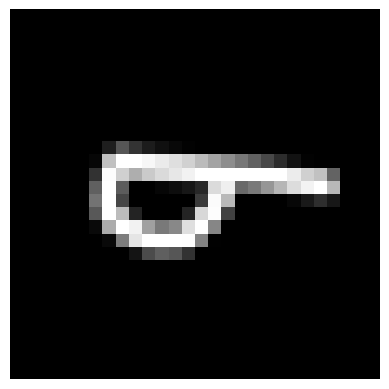

Predicted: P with confidence 77.64%


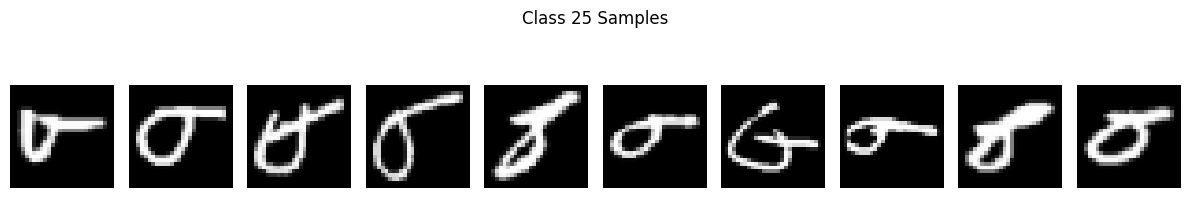

In [ ]:
from PIL import Image
import numpy as np

def correct_emnist_orientation(image):
    """
    Corrects orientation to match EMNIST's format:
    1. Rotate 90° counter-clockwise (left)
    2. Flip horizontally
    """
    image = image.transpose(Image.FLIP_LEFT_RIGHT)  # Flip
    image = image.rotate(90, expand=True)      # Rotate left

    return image

# Example: Preprocess a handwritten "A" (normal orientation)
img = Image.open("test.png").convert("L")  # Grayscale
img_emnist_style = correct_emnist_orientation(img)  # Now matches EMNIST format
img_emnist_style.save("test.png")# Example usage with an image file
image_path = 'test.png'  # Replace with your image path
predicted_char, confidence = predict_letter(image_path, show_image=True)
print(f"Predicted: {predicted_char} with confidence {confidence:.2%}")
show_class_samples(train_dataset, get_class_id(predicted_char))

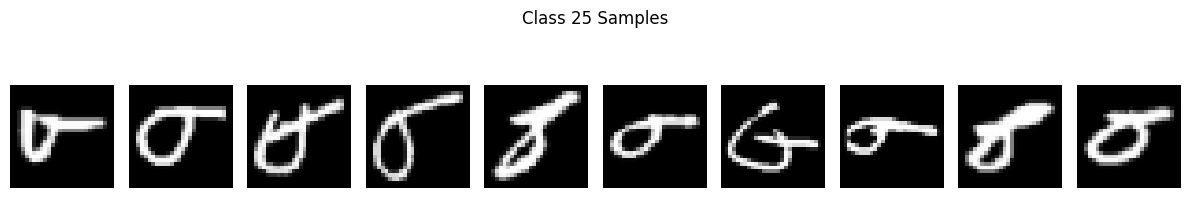

In [ ]:
show_class_samples(train_dataset, get_class_id('P'))